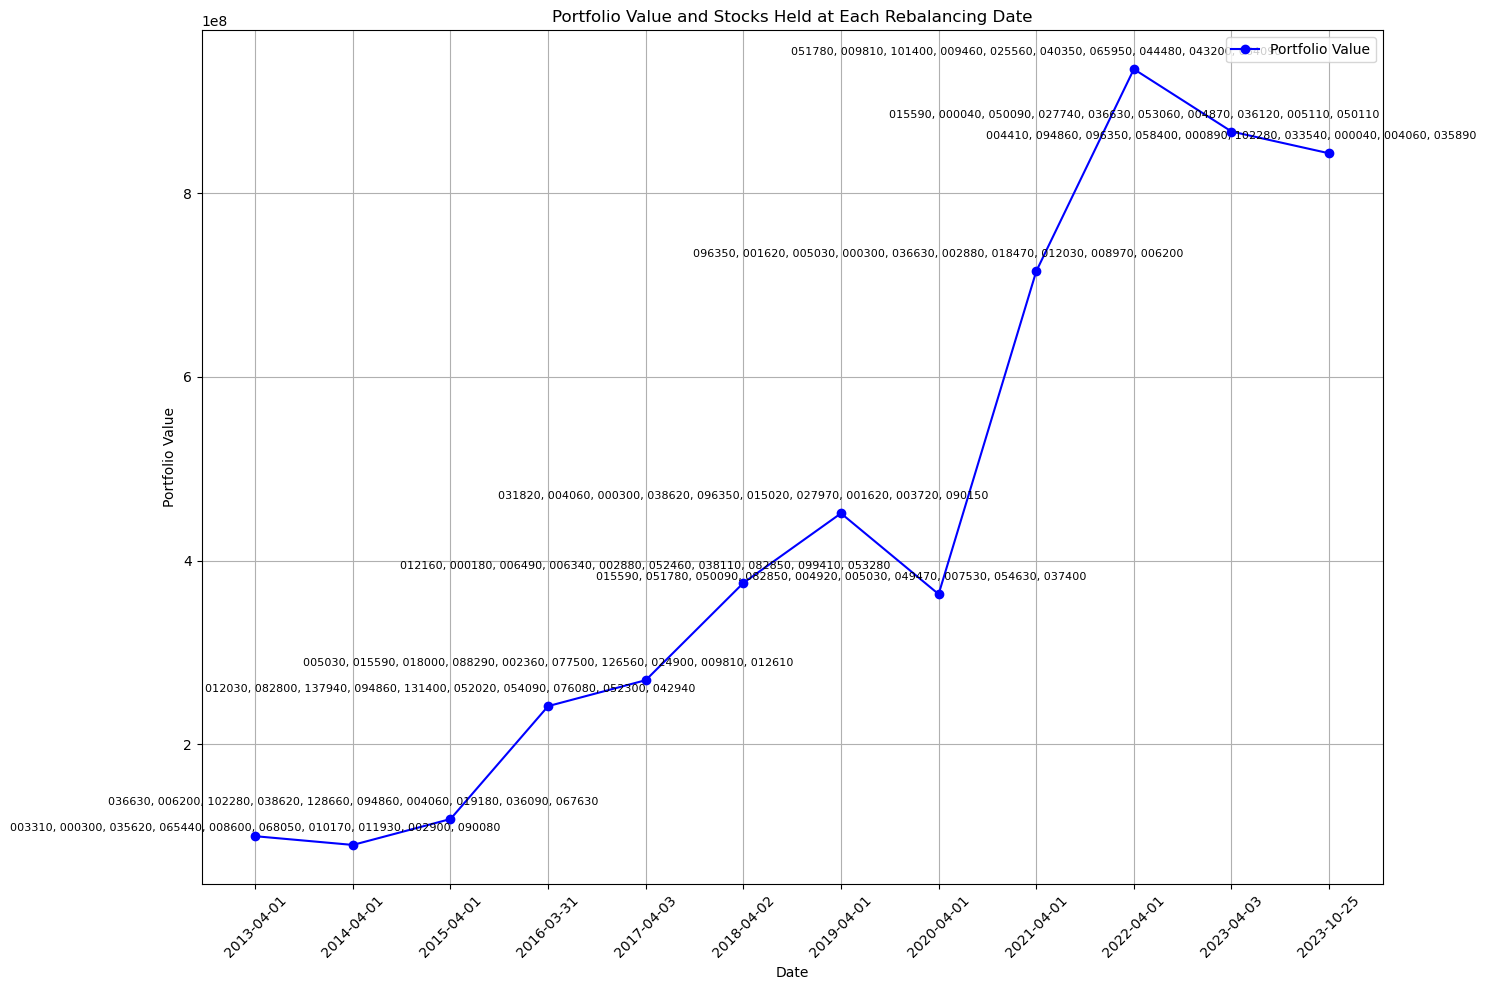

(0.19413195990083243,
 -0.19487782154174116,
 2.2287577228793767,
 740.6744804086452)

In [7]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로드하기
close_df = pd.read_csv('close_df.csv')

# 데이터셋 내의 최신 날짜를 구하기
max_date = close_df['Date'].max()

# 리밸런싱일 정의하기
rebalancing_dates = ['2013-04-01', '2014-04-01', '2015-04-01', '2016-03-31', '2017-04-03', '2018-04-02', '2019-04-01', 
                     '2020-04-01', '2021-04-01', '2022-04-01', '2023-04-03']

# 초기 자본 및 거래 비용 설정
initial_capital = 100000000  # 1억 원
transaction_fee = 0.0015  # 0.15%

# 포트폴리오 값 변화를 저장할 리스트 초기화
portfolio_values = [initial_capital]
# 보유 종목을 저장할 리스트 초기화
held_stocks = []

# 각 리밸런싱일마다 반복
for idx, date in enumerate(rebalancing_dates):
    start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(date)
    
    period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
    
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    volatility = period_df[dropped_stocks].iloc[-60:].std()
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    # 보유 종목 저장
    held_stocks.append(selected_stocks)
    
    amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
    next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
    next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
    
    returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
    portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
    portfolio_values.append(portfolio_value)

# 결과 시각화하기
plt.figure(figsize=(15, 10))
plt.plot(rebalancing_dates + [max_date], portfolio_values, marker='o', linestyle='-', color='b', label='Portfolio Value')
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(held_stocks[i])
    plt.annotate(stocks_str, (date, portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
plt.title('Portfolio Value and Stocks Held at Each Rebalancing Date')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 주어진 성과 평가 지표 계산 함수
def performance_metrics(portfolio_values, rebalancing_dates):
    daily_returns = [0] + [(portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1] for i in range(1, len(portfolio_values))]
    cagr = ((portfolio_values[-1] / portfolio_values[0]) ** (1/len(rebalancing_dates))) - 1
    rolling_max = np.maximum.accumulate(portfolio_values)
    daily_drawdown = portfolio_values / rolling_max - 1.0
    mdd = np.min(daily_drawdown)
    sharpe_ratio = np.mean(daily_returns[1:]) / np.std(daily_returns[1:]) * np.sqrt(len(rebalancing_dates))
    return cagr, mdd, sharpe_ratio

# 포트폴리오 값, 주가 수량 및 주식 가격을 계산하는 함수
def compute_portfolio(close_df, rebalancing_dates, initial_capital, transaction_fee):
    portfolio_values = [initial_capital]
    held_stocks = []
    stock_amounts = []
    stock_prices = []
    
    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)
        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
        volatility = period_df[dropped_stocks].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
        held_stocks.append(selected_stocks)
        amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
        next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else close_df['Date'].max()
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
        portfolio_values.append(portfolio_value)
        stock_amounts.append((amount_per_stock / next_period_df[selected_stocks].iloc[0]).tolist())
        stock_prices.append(next_period_df[selected_stocks].iloc[0].tolist())
    
    return portfolio_values, held_stocks, stock_amounts, stock_prices

# 포트폴리오 값, 주가 수량 및 주식 가격 계산
rebalancing_dates_extended = rebalancing_dates + [close_df['Date'].max()]
portfolio_values, held_stocks, stock_amounts, stock_prices = compute_portfolio(close_df, rebalancing_dates_extended, initial_capital, transaction_fee)

# 성과 평가 지표 계산
cagr, mdd, sharpe_ratio = performance_metrics(portfolio_values, rebalancing_dates_extended)
total_return = (portfolio_values[-1] / portfolio_values[0] - 1) * 100  # 전체 기간 수익률

cagr, mdd, sharpe_ratio, total_return



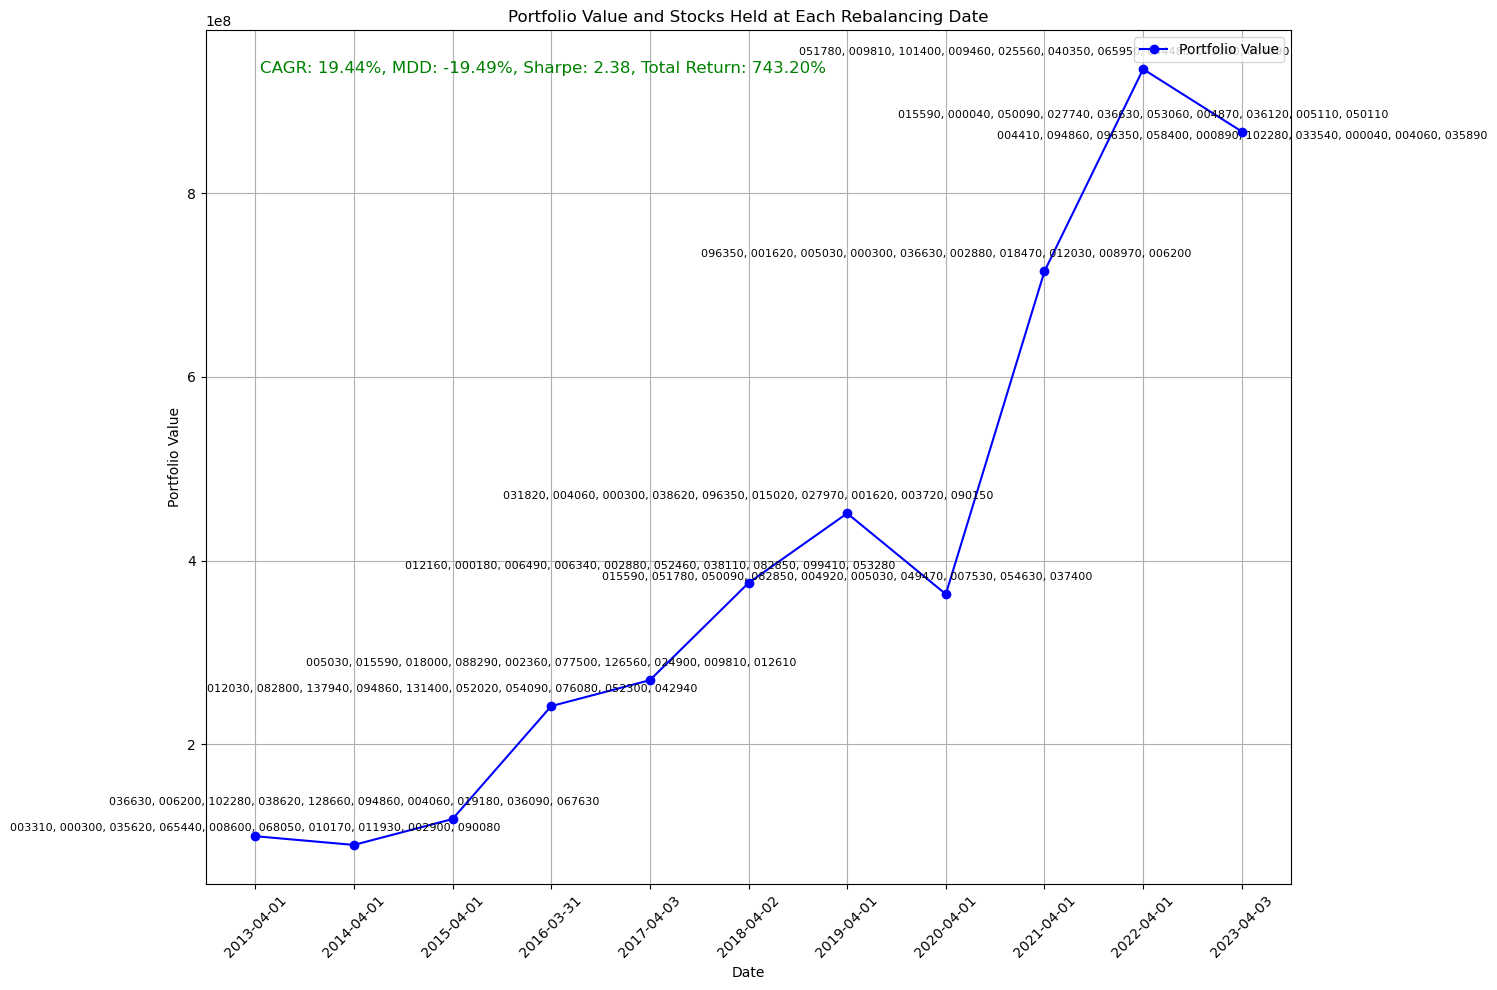

In [9]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로드하기
close_df = pd.read_csv('close_df.csv')

# 데이터셋 내의 최신 날짜를 구하기
max_date = close_df['Date'].max()

# 리밸런싱일 정의하기
rebalancing_dates = ['2013-04-01', '2014-04-01', '2015-04-01', '2016-03-31', '2017-04-03', '2018-04-02', '2019-04-01', 
                     '2020-04-01', '2021-04-01', '2022-04-01', '2023-04-03']

# 초기 자본 및 거래 비용 설정
initial_capital = 100000000  # 1억 원
transaction_fee = 0.0015  # 0.15%

# 포트폴리오 값 변화를 저장할 리스트 초기화
portfolio_values = [initial_capital]
# 보유 종목을 저장할 리스트 초기화
held_stocks = []

# 각 리밸런싱일마다 반복
for idx, date in enumerate(rebalancing_dates):
    start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(date)
    
    period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
    
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    volatility = period_df[dropped_stocks].iloc[-60:].std()
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    # 보유 종목 저장
    held_stocks.append(selected_stocks)
    
    amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
    next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
    next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
    
    returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
    portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
    portfolio_values.append(portfolio_value)

# 주어진 성과 평가 지표 계산 함수
def performance_metrics(portfolio_values, rebalancing_dates):
    daily_returns = [0] + [(portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1] for i in range(1, len(portfolio_values))]
    cagr = ((portfolio_values[-1] / portfolio_values[0]) ** (1/len(rebalancing_dates))) - 1
    rolling_max = np.maximum.accumulate(portfolio_values)
    daily_drawdown = portfolio_values / rolling_max - 1.0
    mdd = np.min(daily_drawdown)
    sharpe_ratio = np.mean(daily_returns[1:]) / np.std(daily_returns[1:]) * np.sqrt(len(rebalancing_dates))
    return cagr, mdd, sharpe_ratio

# 성과 평가 지표 계산
cagr, mdd, sharpe_ratio = performance_metrics(portfolio_values, rebalancing_dates + [max_date])
total_return = (portfolio_values[-1] / portfolio_values[0] - 1) * 100  # 전체 기간 수익률

# Adjusting the plot_dates for correct plotting
plot_dates = rebalancing_dates + [max_date] if len(rebalancing_dates) + 1 < len(portfolio_values) else rebalancing_dates

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the portfolio values
ax.plot(plot_dates, portfolio_values[:len(plot_dates)], marker='o', linestyle='-', color='b', label='Portfolio Value')

# Annotate held stocks on the graph
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(held_stocks[i])
    ax.annotate(stocks_str, (date, portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Display performance metrics on the graph
metrics_str = (f'CAGR: {cagr*100:.2f}%, MDD: {mdd*100:.2f}%, '
               f'Sharpe: {sharpe_ratio:.2f}, Total Return: {total_return:.2f}%')
ax.annotate(metrics_str, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='green')

# Set titles and labels
ax.set_title('Portfolio Value and Stocks Held at Each Rebalancing Date')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.legend()
ax.grid(True)
ax.set_xticks(plot_dates)
ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd

# 데이터 로드하기
close_df = pd.read_csv('close_df.csv')

# 리밸런싱일 정의하기
rebalancing_dates = ['2013-04-01', '2014-04-01', '2015-04-01', '2016-03-31', '2017-04-03', '2018-04-02', '2019-04-01', 
                     '2020-04-01', '2021-04-01', '2022-04-01', '2023-04-03']

# 보유 종목을 저장할 딕셔너리 초기화
held_stocks_dict = {}

# 각 리밸런싱일마다 반복
for idx, date in enumerate(rebalancing_dates):
    start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(date)
    
    period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
    
    price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
    dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
    
    volatility = period_df[dropped_stocks].iloc[-60:].std()
    selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
    
    # 보유 종목 저장
    held_stocks_dict[date] = selected_stocks

# 결과 출력
for date, stocks in held_stocks_dict.items():
    print(f"Date: {date}, Selected Stocks: {stocks}")


Date: 2013-04-01, Selected Stocks: ['003310', '000300', '035620', '065440', '008600', '068050', '010170', '011930', '002900', '090080']
Date: 2014-04-01, Selected Stocks: ['036630', '006200', '102280', '038620', '128660', '094860', '004060', '019180', '036090', '067630']
Date: 2015-04-01, Selected Stocks: ['012030', '082800', '137940', '094860', '131400', '052020', '054090', '076080', '052300', '042940']
Date: 2016-03-31, Selected Stocks: ['005030', '015590', '018000', '088290', '002360', '077500', '126560', '024900', '009810', '012610']
Date: 2017-04-03, Selected Stocks: ['012160', '000180', '006490', '006340', '002880', '052460', '038110', '082850', '099410', '053280']
Date: 2018-04-02, Selected Stocks: ['031820', '004060', '000300', '038620', '096350', '015020', '027970', '001620', '003720', '090150']
Date: 2019-04-01, Selected Stocks: ['015590', '051780', '050090', '082850', '004920', '005030', '049470', '007530', '054630', '037400']
Date: 2020-04-01, Selected Stocks: ['096350', '0

In [13]:
import bt
import pandas as pd

# 데이터 로드
close_df = pd.read_csv('close_df.csv')
close_df['Date'] = pd.to_datetime(close_df['Date'])
close_df.set_index('Date', inplace=True)

# 리밸런싱일 정의
rebalancing_dates = ['2013-04-01', '2014-04-01', '2015-04-01', '2016-03-31', '2017-04-03', '2018-04-02', 
                     '2019-04-01', '2020-04-01', '2021-04-01', '2022-04-01', '2023-04-03']

# 각 리밸런싱일에 선택된 종목코드
selected_stocks = [
    ['003310', '000300', '035620', '065440', '008600', '068050', '010170', '011930', '002900', '090080'],
    ['036630', '006200', '102280', '038620', '128660', '094860', '004060', '019180', '036090', '067630'],
    ['012030', '082800', '137940', '094860', '131400', '052020', '054090', '076080', '052300', '042940'],
    ['005030', '015590', '018000', '088290', '002360', '077500', '126560', '024900', '009810', '012610'],
    ['012160', '000180', '006490', '006340', '002880', '052460', '038110', '082850', '099410', '053280'],
    ['031820', '004060', '000300', '038620', '096350', '015020', '027970', '001620', '003720', '090150'],
    ['015590', '051780', '050090', '082850', '004920', '005030', '049470', '007530', '054630', '037400'],
    ['096350', '001620', '005030', '000300', '036630', '002880', '018470', '012030', '008970', '006200'],
    ['051780', '009810', '101400', '009460', '025560', '040350', '065950', '044480', '043200', '064090'],
    ['015590', '000040', '050090', '027740', '036630', '053060', '004870', '036120', '005110', '050110'],
    ['004410', '094860', '096350', '058400', '000890', '102280', '033540', '000040', '004060', '035890']
]

# 백테스팅 전략 정의
def strategy(selected_stocks, rebalancing_dates, name):
    s = bt.Strategy(name, 
                    [bt.algos.RunAfterDate(rebalancing_dates[0]),
                     bt.algos.RunOnDate(*rebalancing_dates),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()])
    
    data = close_df[selected_stocks].copy()
    return bt.Backtest(s, data)

# 백테스팅 실행
bt_results = bt.run(strategy(selected_stocks, rebalancing_dates, 'Equal_Weight'))

# 결과 시각화
bt_results.plot()


KeyError: "None of [Index([('003310', '000300', '035620', '065440', '008600', '068050', '010170', '011930', '002900', '090080'),\n       ('036630', '006200', '102280', '038620', '128660', '094860', '004060', '019180', '036090', '067630'),\n       ('012030', '082800', '137940', '094860', '131400', '052020', '054090', '076080', '052300', '042940'),\n       ('005030', '015590', '018000', '088290', '002360', '077500', '126560', '024900', '009810', '012610'),\n       ('012160', '000180', '006490', '006340', '002880', '052460', '038110', '082850', '099410', '053280'),\n       ('031820', '004060', '000300', '038620', '096350', '015020', '027970', '001620', '003720', '090150'),\n       ('015590', '051780', '050090', '082850', '004920', '005030', '049470', '007530', '054630', '037400'),\n       ('096350', '001620', '005030', '000300', '036630', '002880', '018470', '012030', '008970', '006200'),\n       ('051780', '009810', '101400', '009460', '025560', '040350', '065950', '044480', '043200', '064090'),\n       ('015590', '000040', '050090', '027740', '036630', '053060', '004870', '036120', '005110', '050110'),\n       ('004410', '094860', '096350', '058400', '000890', '102280', '033540', '000040', '004060', '035890')],\n      dtype='object')] are in the [columns]"

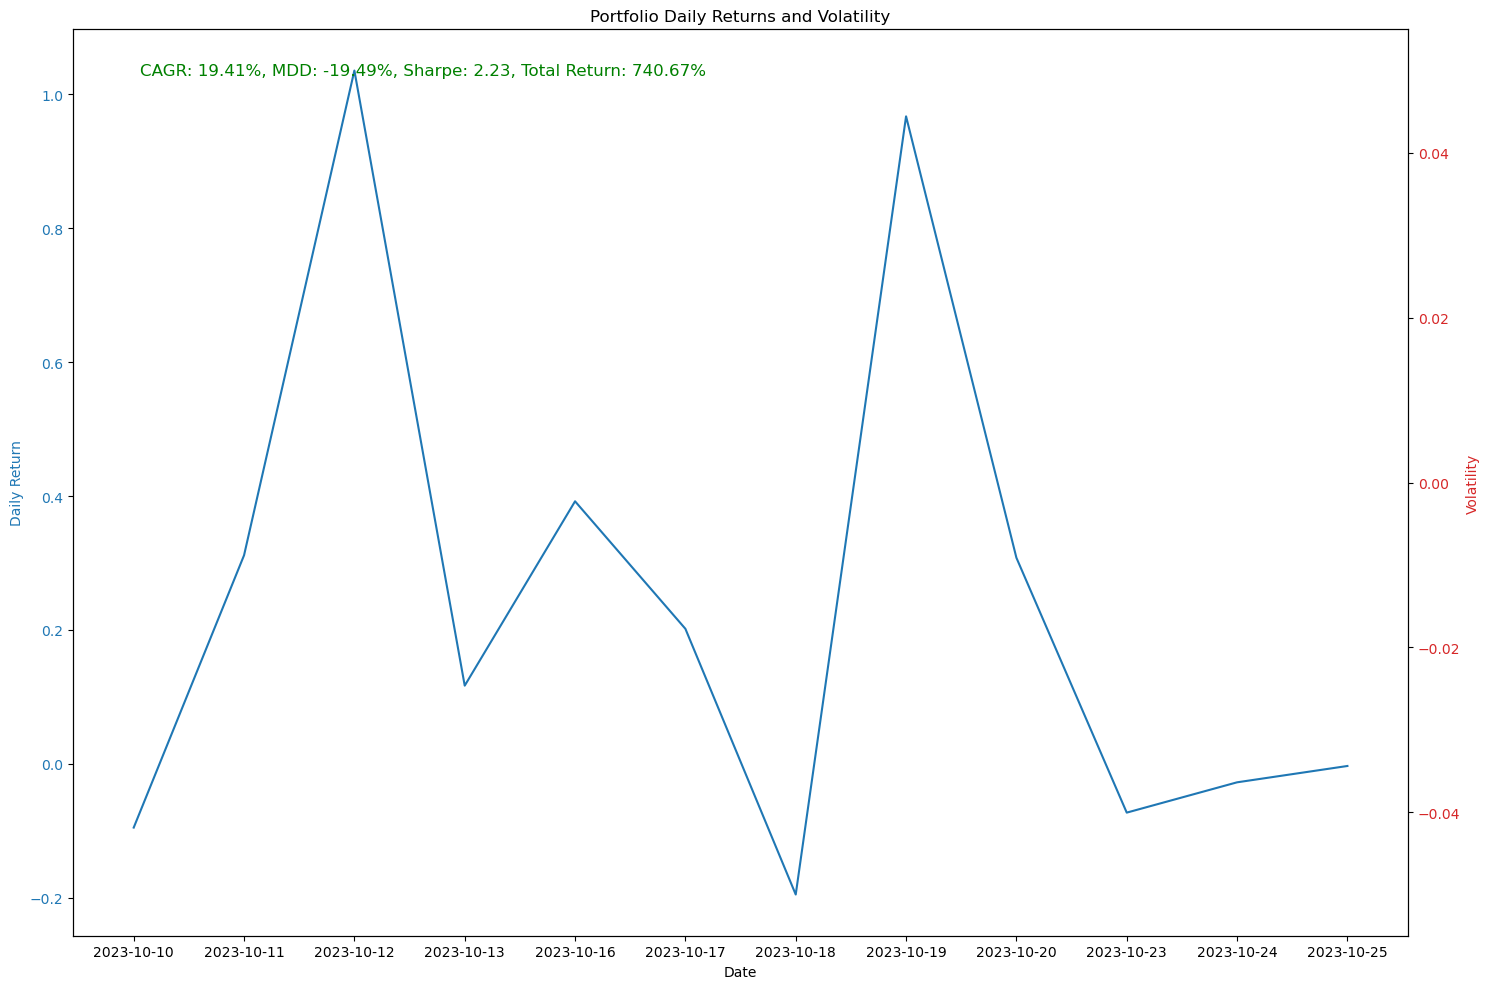

In [8]:
# Complete code

# Necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
close_df = pd.read_csv('close_df.csv')

# Get the latest date in the dataset
max_date = close_df['Date'].max()

# Define rebalancing dates
rebalancing_dates = ['2013-04-01', '2014-04-01', '2015-04-01', '2016-03-31', '2017-04-03', '2018-04-02', '2019-04-01', 
                     '2020-04-01', '2021-04-01', '2022-04-01', '2023-04-03']

# Set initial capital and transaction fee
initial_capital = 100000000  # 1억 원
transaction_fee = 0.0015  # 0.15%

# Performance metrics function
def performance_metrics(portfolio_values, rebalancing_dates):
    daily_returns = [0] + [(portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1] for i in range(1, len(portfolio_values))]
    cagr = ((portfolio_values[-1] / portfolio_values[0]) ** (1/len(rebalancing_dates))) - 1
    rolling_max = np.maximum.accumulate(portfolio_values)
    daily_drawdown = portfolio_values / rolling_max - 1.0
    mdd = np.min(daily_drawdown)
    sharpe_ratio = np.mean(daily_returns[1:]) / np.std(daily_returns[1:]) * np.sqrt(len(rebalancing_dates))
    return cagr, mdd, sharpe_ratio

# Portfolio computation function
def compute_portfolio(close_df, rebalancing_dates, initial_capital, transaction_fee):
    portfolio_values = [initial_capital]
    held_stocks = []
    stock_amounts = []
    stock_prices = []
    
    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)
        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
        volatility = period_df[dropped_stocks].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
        held_stocks.append(selected_stocks)
        amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
        next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else close_df['Date'].max()
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
        portfolio_values.append(portfolio_value)
        stock_amounts.append((amount_per_stock / next_period_df[selected_stocks].iloc[0]).tolist())
        stock_prices.append(next_period_df[selected_stocks].iloc[0].tolist())
    
    return portfolio_values, held_stocks, stock_amounts, stock_prices

# Compute the daily returns of the portfolio
def compute_daily_returns(close_df, rebalancing_dates, initial_capital, transaction_fee):
    daily_returns = []
    portfolio_values = [initial_capital]
    rebalancing_dates_extended = rebalancing_dates + [close_df['Date'].max()]
    portfolio_values, _, _, _ = compute_portfolio(close_df, rebalancing_dates_extended, initial_capital, transaction_fee)
    
    for i in range(1, len(portfolio_values)):
        daily_return = (portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1]
        daily_returns.append(daily_return)
    
    return daily_returns, portfolio_values

# Calculate daily returns and portfolio values
daily_returns, portfolio_values = compute_daily_returns(close_df, rebalancing_dates, initial_capital, transaction_fee)

# Adjust the date range to match the length of daily returns
adjusted_dates = close_df['Date'].iloc[-len(daily_returns):]

# Convert the daily returns to a DataFrame for further analysis
daily_returns_df = pd.DataFrame({
    'Date': adjusted_dates,
    'Daily Return': daily_returns
})

# Calculate daily volatility
daily_returns_df['Volatility'] = daily_returns_df['Daily Return'].rolling(window=30).std()

# Compute the performance metrics
cagr, mdd, sharpe_ratio = performance_metrics(portfolio_values, rebalancing_dates_extended)
total_return = (portfolio_values[-1] / portfolio_values[0] - 1) * 100

# Visualization
fig, ax1 = plt.subplots(figsize=(15, 10))

# Plotting daily returns
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return', color=color)
ax1.plot(daily_returns_df['Date'], daily_returns_df['Daily Return'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Portfolio Daily Returns and Volatility')

# Create a second y-axis to plot volatility
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Volatility', color=color)
ax2.plot(daily_returns_df['Date'], daily_returns_df['Volatility'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Display performance metrics
metrics_str = f'CAGR: {cagr*100:.2f}%, MDD: {mdd*100:.2f}%, Sharpe: {sharpe_ratio:.2f}, Total Return: {total_return:.2f}%'
ax1.annotate(metrics_str, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, color='green')

fig.tight_layout()
plt.show()


In [6]:
# 주어진 성과 평가 지표 계산 함수
def performance_metrics(portfolio_values, rebalancing_dates):
    daily_returns = [0] + [(portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1] for i in range(1, len(portfolio_values))]
    cagr = ((portfolio_values[-1] / portfolio_values[0]) ** (1/len(rebalancing_dates))) - 1
    rolling_max = np.maximum.accumulate(portfolio_values)
    daily_drawdown = portfolio_values / rolling_max - 1.0
    mdd = np.min(daily_drawdown)
    sharpe_ratio = np.mean(daily_returns[1:]) / np.std(daily_returns[1:]) * np.sqrt(len(rebalancing_dates))
    return cagr, mdd, sharpe_ratio

# 포트폴리오 값, 주가 수량 및 주식 가격을 계산하는 함수
def compute_portfolio(close_df, rebalancing_dates, initial_capital, transaction_fee):
    portfolio_values = [initial_capital]
    held_stocks = []
    stock_amounts = []
    stock_prices = []
    
    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)
        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()
        volatility = period_df[dropped_stocks].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()
        held_stocks.append(selected_stocks)
        amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
        next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else close_df['Date'].max()
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
        portfolio_values.append(portfolio_value)
        stock_amounts.append((amount_per_stock / next_period_df[selected_stocks].iloc[0]).tolist())
        stock_prices.append(next_period_df[selected_stocks].iloc[0].tolist())
    
    return portfolio_values, held_stocks, stock_amounts, stock_prices

# 포트폴리오 값, 주가 수량 및 주식 가격 계산
rebalancing_dates_extended = rebalancing_dates + [close_df['Date'].max()]
portfolio_values, held_stocks, stock_amounts, stock_prices = compute_portfolio(close_df, rebalancing_dates_extended, initial_capital, transaction_fee)

# 성과 평가 지표 계산
cagr, mdd, sharpe_ratio = performance_metrics(portfolio_values, rebalancing_dates_extended)
total_return = (portfolio_values[-1] / portfolio_values[0] - 1) * 100  # 전체 기간 수익률

cagr, mdd, sharpe_ratio, total_return


(0.19413195990083243,
 -0.19487782154174116,
 2.2287577228793767,
 740.6744804086452)

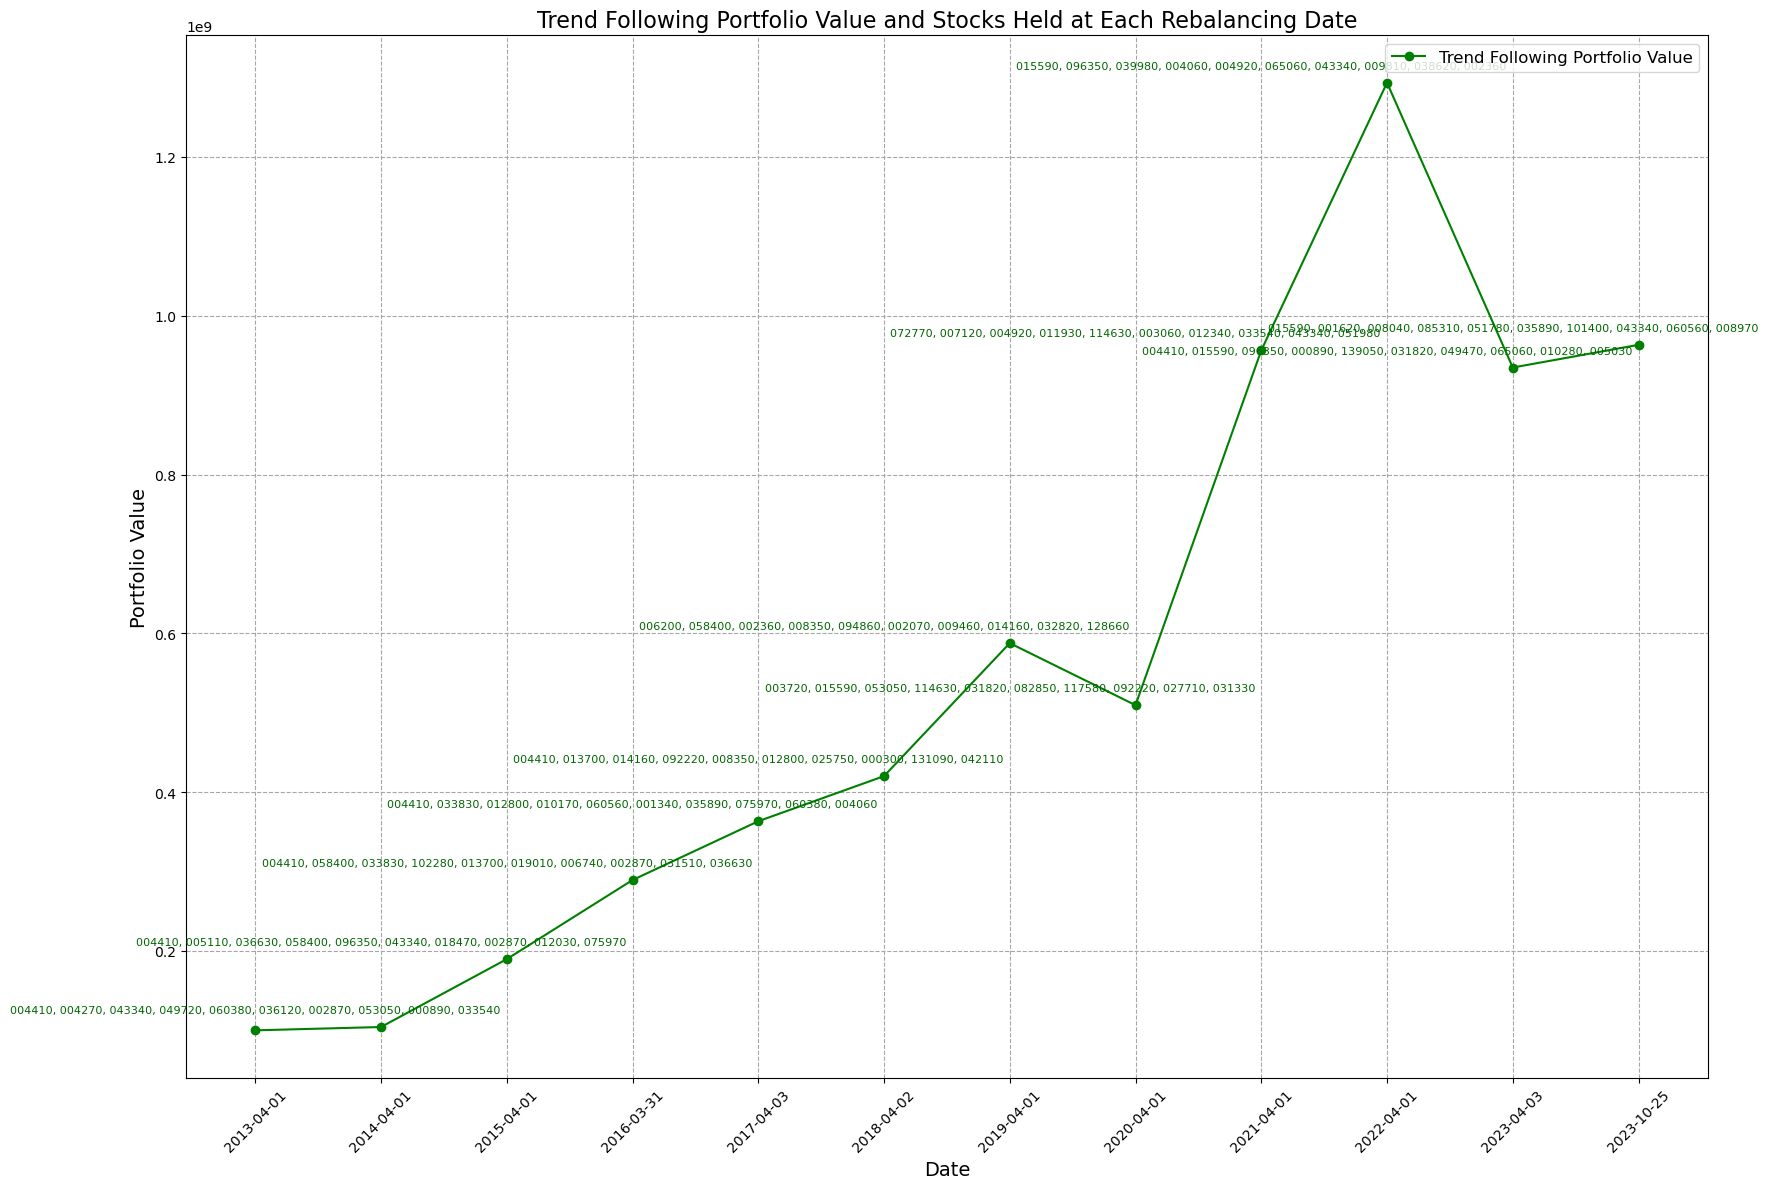

In [2]:
# 추세추종 전략 설정값
N = 50  # 이동평균 기간
M = 10  # 포트폴리오에 포함할 종목 수

# 포트폴리오 값 변화를 저장할 리스트 초기화
trend_portfolio_values = [initial_capital]
# 보유 종목을 저장할 리스트 초기화
trend_held_stocks = []

# 각 리밸런싱일마다 반복
for idx, date in enumerate(rebalancing_dates):
    start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
    end_date = pd.to_datetime(date)
    
    period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')
    
    # 50일 이동평균 계산
    moving_average = period_df.rolling(window=N).mean().iloc[-1]
    current_price = period_df.iloc[-1]
    
    # 매수 시그널이 발생한 종목 선택
    buy_signals = current_price[current_price > moving_average].index.tolist()
    
    # 선택된 종목 중 변동성이 낮은 상위 10개의 종목 선택
    volatility = period_df[buy_signals].iloc[-60:].std()
    selected_stocks = volatility.nsmallest(M).index.tolist() if len(volatility) >= M else volatility.index.tolist()
    
    # 보유 종목 저장
    trend_held_stocks.append(selected_stocks)
    
    amount_per_stock = (trend_portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
    next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
    next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')
    
    returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
    portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
    trend_portfolio_values.append(portfolio_value)

# 결과 시각화
plt.figure(figsize=(18, 12))
plt.plot(rebalancing_dates + [max_date], trend_portfolio_values, marker='o', linestyle='-', color='g', label='Trend Following Portfolio Value')
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(trend_held_stocks[i])
    plt.annotate(stocks_str, (date, trend_portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkgreen')
plt.title('Trend Following Portfolio Value and Stocks Held at Each Rebalancing Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", c='0.65')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
def mean_reversion_strategy(rebalancing_dates, close_df):
    portfolio_values = [initial_capital]
    held_stocks = []
    
    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)

        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')

        price_drop = (period_df.iloc[-1] - period_df.iloc[0]) / period_df.iloc[0]
        dropped_stocks = price_drop[price_drop <= -0.30].index.tolist()

        volatility = period_df[dropped_stocks].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(10).index.tolist() if len(volatility) >= 10 else volatility.index.tolist()

        held_stocks.append(selected_stocks)

        amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
        next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')

        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
        portfolio_values.append(portfolio_value)
    
    return portfolio_values, held_stocks


def trend_following_strategy(rebalancing_dates, close_df):
    portfolio_values = [initial_capital]
    held_stocks = []

    for idx, date in enumerate(rebalancing_dates):
        start_date = pd.to_datetime(date) - pd.DateOffset(years=1)
        end_date = pd.to_datetime(date)

        period_df = close_df[(close_df['Date'] >= start_date.strftime('%Y-%m-%d')) & (close_df['Date'] < end_date.strftime('%Y-%m-%d'))].drop(columns='Date')

        moving_average = period_df.rolling(window=N).mean().iloc[-1]
        current_price = period_df.iloc[-1]

        buy_signals = current_price[current_price > moving_average].index.tolist()

        volatility = period_df[buy_signals].iloc[-60:].std()
        selected_stocks = volatility.nsmallest(M).index.tolist() if len(volatility) >= M else volatility.index.tolist()

        held_stocks.append(selected_stocks)

        amount_per_stock = (portfolio_values[-1] * (1 - transaction_fee)) / len(selected_stocks)
        next_date = rebalancing_dates[idx + 1] if idx + 1 < len(rebalancing_dates) else max_date
        next_period_df = close_df[(close_df['Date'] >= date) & (close_df['Date'] <= next_date)].drop(columns='Date')

        returns = (next_period_df[selected_stocks].iloc[-1] - next_period_df[selected_stocks].iloc[0]) / next_period_df[selected_stocks].iloc[0]
        portfolio_value = sum(amount_per_stock * (1 + returns) * (1 - transaction_fee))
        portfolio_values.append(portfolio_value)
    
    return portfolio_values, held_stocks


# 실행 및 시각화
mr_portfolio_values, mr_held_stocks = mean_reversion_strategy(rebalancing_dates, close_df)
tf_portfolio_values, tf_held_stocks = trend_following_strategy(rebalancing_dates, close_df)

# 성과 평가 지표 계산 함수
def performance_metrics(portfolio_values, rebalancing_dates):
    daily_returns = [0] + [(portfolio_values[i] - portfolio_values[i-1]) / portfolio_values[i-1] for i in range(1, len(portfolio_values))]
    cagr = ((portfolio_values[-1] / portfolio_values[0]) ** (1/len(rebalancing_dates))) - 1
    rolling_max = np.maximum.accumulate(portfolio_values)
    daily_drawdown = portfolio_values / rolling_max - 1.0
    mdd = np.min(daily_drawdown)
    sharpe_ratio = np.mean(daily_returns[1:]) / np.std(daily_returns[1:]) * np.sqrt(len(rebalancing_dates))
    return cagr, mdd, sharpe_ratio

mr_metrics = performance_metrics(mr_portfolio_values, rebalancing_dates)
tf_metrics = performance_metrics(tf_portfolio_values, rebalancing_dates)

mr_metrics, tf_metrics


((0.21387959590705896, -0.19487782154174116, 2.275328435373096),
 (0.22866288136842527, -0.277316811678917, 2.6298884511862957))

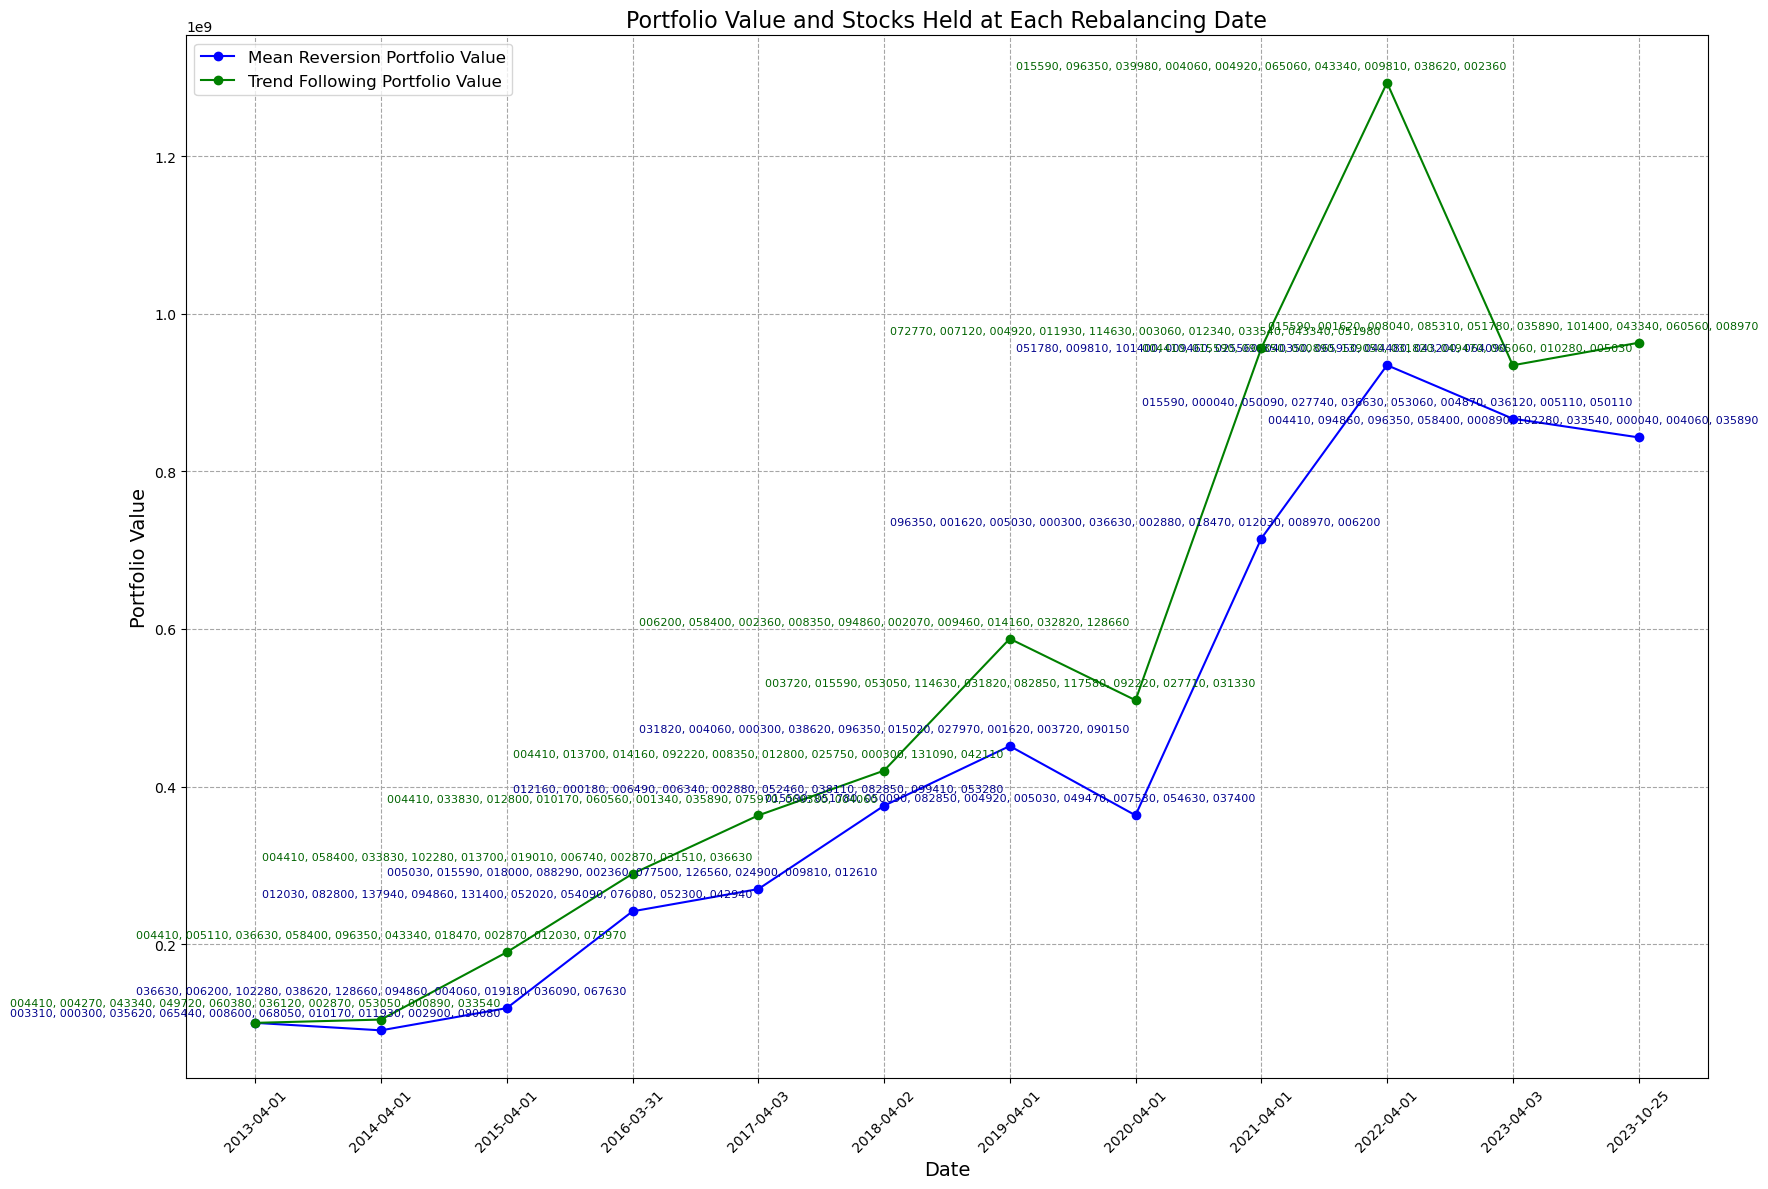

In [4]:
# 시각화
plt.figure(figsize=(18, 12))

# 평균 회귀 전략 결과 시각화
plt.plot(rebalancing_dates + [max_date], mr_portfolio_values, marker='o', linestyle='-', color='b', label='Mean Reversion Portfolio Value')
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(mr_held_stocks[i])
    plt.annotate(stocks_str, (date, mr_portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkblue')

# 추세 추종 전략 결과 시각화
plt.plot(rebalancing_dates + [max_date], tf_portfolio_values, marker='o', linestyle='-', color='g', label='Trend Following Portfolio Value')
for i, date in enumerate(rebalancing_dates):
    stocks_str = ', '.join(tf_held_stocks[i])
    plt.annotate(stocks_str, (date, tf_portfolio_values[i+1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='darkgreen')

plt.title('Portfolio Value and Stocks Held at Each Rebalancing Date', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", c='0.65')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
